# Taller 1 NLP


Integrante: Erich Giussppe Soto Parada

Integrante: Cristobal

## Imports

In [33]:
import numpy as np
from nltk.stem import *
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
import nltk
from langdetect import detect_langs
import unicodedata
import re

## Metricas IR

In [ ]:
def precision(relevance_arr: np.array) -> float:
    """function that evaluates the precicion of set of retrived documents

    Args:
        relevance_arr (np.array): An array containing binary values (1 and 0) indicating 
        whether each document is relevant (1) or not relevant (0). 
        The elements must be ordered by document index, from best to worst.

    Returns:
        float: precision of the retrival list
    """
    return np.mean(relevance_arr)


def precision_at_k(relevance_arr: np.array, k: int) -> float:
    """precision at k, precision obtained slicing ultil the k position

    Args:
        relevance_arr (np.array): An array containing binary values (1 and 0) indicating 
        whether each document is relevant (1) or not relevant (0). 
        The elements must be ordered by document index, from best to worst.
        k (int): k position where the slice is going to be made

    Returns:
        float: precision of the retrival list at k
    """
    return np.mean(relevance_arr[0:k])





def average_precision(relevance_arr: np.array):
    """Funcion to obtain the average pecision in diferent k, 
    only k with document relevance are taking into account

    Args:
        relevance_arr (np.array): An array containing binary values (1 and 0) indicating 
        whether each document is relevant (1) or not relevant (0). 
        The elements must be ordered by document index, from best to worst.
        k (int): k position where the slice is going to be made

    Returns:
        _type_: average precision of the retrival list at k
    """

    precisiones = [
        precision_at_k(relevance_arr, k + 1)
        for k in range(len(relevance_arr))
        if relevance_arr[k] == 1
    ]
    if len(precisiones) == 0:
        return np.float64(0)
    else:
        return np.mean(precisiones)

def recall_at_k(relevance_arr: np.array, number_relevant_doc: int, k: int) -> float:
    """calculates the recall until the k position 

    Args:
        relevance_arr (np.array): _description_
        number_relevant_doc (int): _description_
        k (int): _description_

    Returns:
        float: _description_
    """
    return relevance_arr[0:k].sum() / number_relevant_doc

def mean_average_precision(querys_matrix: np.ndarray) -> float:
    """mean of the average precision across queries

    Args:
        querys_matrix (np.ndarray): A list of lists containg each list being 
        an array containing binary values (1 and 0) indicating 
        whether each document is relevant (1) or not relevant (0). 
        The elements must be ordered by document index, from best to worst.
        k (int): k position where the slice is going to be made

    Returns:
        float: mean average precision for the imput queries 
    """

    # scores = [average_precision(querys_matrix) for row in querys_matrix]
    querys_matrix = np.array(querys_matrix, dtype=object)
    arr_result = np.zeros(len(querys_matrix))
    for i, row in enumerate(querys_matrix):
        arr_result[i] = average_precision(row)  # cada row puede tener tamaño distinto
    return np.mean(arr_result)

def average_recall(relevance_arr: np.array, number_relevant_doc: int) -> float:
    """_summary_

    Args:
        relevance_arr (np.array): _description_
        number_relevant_doc (int): _description_

    Returns:
        float: _description_
    """

    recalls = [
        recall_at_k(relevance_arr, number_relevant_doc, k + 1)
        for k in range(len(relevance_arr))
        if relevance_arr[k] == 1
    ]
    if len(recalls) == 0:
        return np.float64(0)
    else:
        return np.mean(recalls)


def mean_average_recall(querys_matrix: list[np.array], relevant_counts: list[int]) -> float:

    arr_result = np.zeros(len(querys_matrix))
    for i, row in enumerate(querys_matrix):
        arr_result[i] = average_recall(row, relevant_counts[i])
    return np.mean(arr_result)   
def dct_at_one_k(relevance_arr: np.array, k: int) -> float:

    gain = np.sum(relevance_arr)
    discount_factor = np.log2(max(k, 2))
    return gain / discount_factor


def dcg_at_k(relevance_arr: np.array, k: int) -> float:
    expected2 = [
        value / np.log2(max(2, i + 1)) for i, value in enumerate(relevance_arr[:k])
    ]
    expected2 = np.sum(expected2)

    return expected2


def ndcg_at_k(relevance_arr: np.array, k: int) -> float:
    dcg = dcg_at_k(relevance_arr, k)
    ideal_dcg = dcg_at_k(sorted(relevance_arr, reverse=True), k)
    return dcg / ideal_dcg


# TODO faltan las pruebas

In [4]:
# Pruebas


def test_precision():
    assert precision(np.array([0, 0, 0, 1])) == np.float64(0.25)
    assert precision(np.array([1, 1, 1, 1])) == np.float64(1.0)
    assert precision(np.array([0, 0, 0, 0])) == np.float64(0.0)
    assert precision(np.array([1, 0, 1, 0])) == np.float64(0.5)


def test_precision_at_k():
    assert precision_at_k(np.array([0, 0, 0, 1]), 2) == np.float64(0.0)
    assert precision_at_k(np.array([1, 1, 1, 1]), 2) == np.float64(1.0)
    assert precision_at_k(np.array([1, 0, 1, 0]), 2) == np.float64(0.5)
    assert precision_at_k(np.array([1, 0, 1, 0]), 3) == np.float64(2 / 3)


def test_recall_at_k():
    arr = np.array([0, 0, 0, 1])
    assert recall_at_k(arr, number_relevant_doc=1, k=2) == 0.0
    assert recall_at_k(arr, number_relevant_doc=1, k=4) == 1.0
    assert recall_at_k(arr, number_relevant_doc=4, k=1) == 0

    arr = np.array([1, 1, 1, 1])
    assert recall_at_k(arr, number_relevant_doc=4, k=2) == 0.5
    assert recall_at_k(arr, number_relevant_doc=4, k=4) == 1.0

    arr = np.array([1, 0, 1, 0])
    assert recall_at_k(arr, number_relevant_doc=2, k=2) == 0.5
    assert recall_at_k(arr, number_relevant_doc=2, k=3) == 1.0


def test_average_precision():

    relevance_query_2 = [0, 1, 0, 1, 1, 1, 1]
    result = average_precision(relevance_query_2)
    assert np.isclose(result, 0.5961904, atol=1e-6)

    relevance_all = [1, 1, 1, 1]
    assert average_precision(relevance_all) == 1.0

    relevance_none = [0, 0, 0, 0]
    assert average_precision(relevance_none) == 0.0

    relevance_last = [0, 0, 0, 1]
    assert average_precision(relevance_last) == 0.25


def test_mean_average_precision():
    querys_matrix = np.array(
        [[0, 1, 0, 1, 1, 1, 1], [1, 1, 1, 1], [0, 0, 0, 0], [0, 0, 0, 1]], dtype=object
    )

    result = mean_average_precision(querys_matrix)
    expected = np.mean([0.5961904, 1.0, 0.0, 0.25])
    assert np.isclose(result, expected, atol=1e-6)
    querys_matrix = [
        [0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1],
    ]
    result = mean_average_precision(querys_matrix)
    assert np.isclose(result, np.float64(0.471964285714), atol=1e-6)


def test_dcg_at_k():
    rels1 = np.array([1, 1, 1, 1])
    expected1 = 1 / 1 + 1 / 1 + 1 / np.log2(3) + 1 / np.log2(4)
    assert np.isclose(dcg_at_k(rels1, 4), expected1, atol=1e-6)

    rels2 = np.array([1, 0, 0, 0])
    expected1 = 1 / np.log2(2) + 0 / np.log2(2) + 0 / np.log2(3) + 0 / np.log2(4)
    assert np.isclose(dcg_at_k(rels2, 4), 1.0, atol=1e-6)

    rels3 = np.array([3, 2, 3, 0, 1])
    expected3 = 3 / np.log2(2) + 2 / np.log2(2) + 3 / np.log2(3) + 0 + 1 / np.log2(5)
    assert np.isclose(dcg_at_k(rels3, 5), expected3, atol=1e-6)


def test_ndcg_at_k():
    rels1 = np.array([1, 1, 1, 1])
    assert np.isclose(ndcg_at_k(rels1, 4), 1.0, atol=1e-6)

    rels2 = np.array([1, 0, 0, 0])
    assert np.isclose(ndcg_at_k(rels2, 4), 1.0, atol=1e-6)

    rels3 = np.array([3, 2, 3, 0, 1])
    dcg = dcg_at_k(rels3, 5)
    idcg = dcg_at_k(np.sort(rels3)[::-1], 5)
    expected_ndcg = dcg / idcg
    assert np.isclose(ndcg_at_k(rels3, 5), expected_ndcg, atol=1e-6)


test_precision()
print("Se paso la prueba de precision")
test_precision_at_k()
print("Se paso la prueba de precision at k")
test_recall_at_k()
print("Se paso la prueba de recall at k")
test_average_precision()
print("se paso la prueba de average precision")
test_mean_average_precision()
print("Se paso el test de mean average precision")
test_dcg_at_k()
print("Se paso la prueba de dcg_at_k")
test_ndcg_at_k()
print("Se paso la prueba de n_dcg_at_k")

Se paso la prueba de precision
Se paso la prueba de precision at k
Se paso la prueba de recall at k
se paso la prueba de average precision
Se paso el test de mean average precision
Se paso la prueba de dcg_at_k
Se paso la prueba de n_dcg_at_k


## Parte 2: Comparacion de estrategias de motores de busqueda

In [35]:
import xml.etree.ElementTree as ET
import os
from nltk.corpus import stopwords

Docs

In [36]:
list_docs_files = sorted(os.listdir("./data/docs-raw-texts/"))

In [7]:
list_docs_files

['wes2015.d001.naf',
 'wes2015.d002.naf',
 'wes2015.d003.naf',
 'wes2015.d004.naf',
 'wes2015.d005.naf',
 'wes2015.d006.naf',
 'wes2015.d007.naf',
 'wes2015.d008.naf',
 'wes2015.d009.naf',
 'wes2015.d010.naf',
 'wes2015.d011.naf',
 'wes2015.d012.naf',
 'wes2015.d013.naf',
 'wes2015.d014.naf',
 'wes2015.d015.naf',
 'wes2015.d016.naf',
 'wes2015.d017.naf',
 'wes2015.d018.naf',
 'wes2015.d019.naf',
 'wes2015.d020.naf',
 'wes2015.d021.naf',
 'wes2015.d022.naf',
 'wes2015.d023.naf',
 'wes2015.d024.naf',
 'wes2015.d025.naf',
 'wes2015.d026.naf',
 'wes2015.d027.naf',
 'wes2015.d028.naf',
 'wes2015.d029.naf',
 'wes2015.d030.naf',
 'wes2015.d031.naf',
 'wes2015.d032.naf',
 'wes2015.d033.naf',
 'wes2015.d034.naf',
 'wes2015.d035.naf',
 'wes2015.d036.naf',
 'wes2015.d037.naf',
 'wes2015.d038.naf',
 'wes2015.d039.naf',
 'wes2015.d040.naf',
 'wes2015.d041.naf',
 'wes2015.d042.naf',
 'wes2015.d043.naf',
 'wes2015.d044.naf',
 'wes2015.d045.naf',
 'wes2015.d046.naf',
 'wes2015.d047.naf',
 'wes2015.d04

In [8]:
len(nltk.corpus.stopwords.words("english"))

198

In [9]:
len(set(nltk.corpus.stopwords.words("english")))

198

In [10]:
# nltk_stop_words_en = set(
#     nltk.corpus.stopwords.words("english")
# )  # Palabras de parada como you, are, is, ...
# word_tok_nltk_en_sw = [
#     [token for token in doc if token not in nltk_stop_words_en]
#     for doc in word_tok_nltk_en
# ]
# print("Stopwords removal English")
# print(word_tok_nltk_en_sw)

In [101]:
def get_content_and_title(document):
    tree = ET.parse(f"./data/docs-raw-texts/{document}")
    root = tree.getroot()
    file_desc = root.find(".//fileDesc")
    element_raw = root.find("raw")
    if file_desc is not None:
        title = file_desc.attrib.get("title")
    text = f"{title}\n {element_raw.text}"
    return text


def get_content(document):
    tree = ET.parse(f"./data/queries-raw-texts/{document}")
    root = tree.getroot()
    element_raw = root.find("raw")
    return element_raw.text


# def process_text_stop_words(text):
#     text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
#     # Normalizacion
#     text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")
#     text_no_stop_words = set(nltk.corpus.stopwords.words("english"))
#     # Tokenizacion
#     word_tok_nltk_en = nltk.word_tokenize(text)
#     word_tok_nltk_en_sw = [
#         token for token in word_tok_nltk_en if token not in text_no_stop_words
#     ]
#     # Stemming
#     snow_stemmer = nltk.stem.SnowballStemmer("english")
#     nltk_stemedList_en = [snow_stemmer.stem(word) for word in word_tok_nltk_en_sw]
#     return nltk_stemedList_en

import re
import unicodedata
import nltk
from langdetect import detect

STOP_WORDS_EN = nltk.corpus.stopwords.words("english")
STEMMER_EN= nltk.stem.SnowballStemmer("english")

STOP_WORDS_DU = nltk.corpus.stopwords.words("german")
STEMMER_DU = nltk.stem.SnowballStemmer("german")


def process_text_stop_words(text: str):
    # Normalización Unicode -> ASCII
    idioma = detect(text)
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")
    print(text)
    text = text.lower() 
    stopwords = None
    tokenizer = None
    if idioma == "en":
        stopwords = STOP_WORDS_EN
        tokenizer = STEMMER_EN
    else:
        stopwords = STOP_WORDS_DU
        tokenizer = STEMMER_DU
    # Tokenización
    tokens = nltk.word_tokenize(text)
    
    # Filtrado
    clean_tokens = []
    for tok in tokens:
        tok = re.sub(r"[^A-Za-z0-9]+", "", tok)
        if (
            tok                                     
            and tok not in stopwords               
            and (tok.isalpha())    
            and 2 <= len(tokenizer.stem(tok)) <= 20                 
            
        ):
            if tokenizer.stem(tok):
                clean_tokens.append(tokenizer.stem(tok))
    return clean_tokens


In [102]:
tasdfasdfasdf = """A large disadvantage of the BERT network
structure is that no independent sentence embeddings are computed, which makes it difficult to derive sentence embeddings from BERT. To bypass
this limitations, researchers passed single sentences through BERT and then derive a fixed sized
vector by either averaging the outputs"""

In [103]:
process_text_stop_words(tasdfasdfasdf)

A large disadvantage of the BERT network
structure is that no independent sentence embeddings are computed, which makes it difficult to derive sentence embeddings from BERT. To bypass
this limitations, researchers passed single sentences through BERT and then derive a fixed sized
vector by either averaging the outputs


['larg',
 'disadvantag',
 'bert',
 'network',
 'structur',
 'independ',
 'sentenc',
 'embed',
 'comput',
 'make',
 'difficult',
 'deriv',
 'sentenc',
 'embed',
 'bert',
 'bypass',
 'limit',
 'research',
 'pass',
 'singl',
 'sentenc',
 'bert',
 'deriv',
 'fix',
 'size',
 'vector',
 'either',
 'averag',
 'output']

In [104]:
def pruebas_simples():
    text_1 = get_content_and_title("wes2015.d255.naf")
    text_2 = "The rapid growth of digital technologies has transformed nearly every aspect of modern society, from the way we communicate to how we conduct business and even how we think about privacy and security. In particular, the internet has created an environment where information is more accessible than ever before, allowing people to share knowledge instantly across the globe. However, this convenience also comes with challenges, such as the spread of misinformation, the rise of cyberattacks, and increasing concerns about how personal data is collected and used by large corporations. As artificial intelligence and machine learning systems continue to advance, they promise to revolutionize industries ranging from healthcare to transportation, but they also raise ethical questions about bias, accountability, and the future of human employment. Ultimately, the challenge for policymakers, researchers, and citizens alike is to balance the benefits of innovation with the responsibility of ensuring that technology serves the common good."
    print(process_text_stop_words(text_1))

In [105]:
class InvertedIndex:
    def __init__(self, length=100_000):
        self.hash_map = np.full(length, None, dtype=object)
        self.length = length
        self.num_elements = 0
        self.word_list = []
        self.docs = []

    def _get_index_hash(self, word):
        word_index = hash(word) % self.length
        return word_index

    def insert(
        self,
        word,
        doc_index,
    ):
        if word not in self.word_list:
            self.word_list.append(word)
        self._check_load()
        # Calculate index
        word_index = self._get_index_hash(word)
        # Insert

        element_in_list = self.hash_map[word_index]

        if element_in_list is None:
            # posting_list ahora guarda pares [doc_index, tf]
            self.hash_map[word_index] = [[word, 1, [[doc_index, 1]]]]
            self.num_elements += 1
            return True
        else:
            i = 0
            while True:
                if i < len(element_in_list):
                    if element_in_list[i][0] == word:
                        # Buscar si el doc ya existe en la posting list
                        posting_list = element_in_list[i][2]
                        j = 0
                        while j < len(posting_list):
                            if posting_list[j][0] == doc_index:
                                # Incrementar TF para (word, doc)
                                posting_list[j][1] += 1
                                return True
                            j += 1
                        # Nuevo doc para la palabra: df += 1, tf inicia en 1
                        element_in_list[i][1] += 1
                        posting_list.append([doc_index, 1])
                        return True
                else:
                    element_in_list.append([word, 1, [[doc_index, 1]]])
                    self.num_elements += 1
                    return True
                i += 1
        return False

    def _check_load(self):
        load_factor = self.num_elements / self.length
        if load_factor > 0.7:
            self._rehash()

    def _rehash(self):
        old_hash = self.hash_map
        new_list_hash = InvertedIndex(length=self.length * 2)
        new_length = self.length * 2
        for bucket in old_hash:
            if bucket is None:
                continue
            for word, doc_freq, posting_list in bucket:
                # Reinsertar respetando los TF
                for doc_index, tf in posting_list:
                    for _ in range(tf):
                        new_list_hash.insert(word, doc_index)
        self.hash_map = new_list_hash.hash_map
        self.length = new_length
        self.num_elements = new_list_hash.num_elements

    def get(self, word):
        index_hash = self._get_index_hash(word)
        bucket = self.hash_map[index_hash]
        if bucket is None:
            return None
        for element in bucket:
            if element[0] == word:
                return element
        return False

    @staticmethod
    def algoritmo_de_mezcla(list1, list2, is_and=True):  # asume unicidad
        i, j = 0, 0
        lista_final = []
        if is_and:
            while i < len(list1) and j < len(list2):
                if list1[i] > list2[j]:
                    j += 1
                elif list1[i] == list2[j]:
                    lista_final.append(list1[i])
                    j += 1
                    i += 1
                else:
                    i += 1
        else:
            while i < len(list1) and j < len(list2):
                if list1[i] > list2[j]:
                    j += 1
                elif list1[i] == list2[j]:
                    j += 1
                    i += 1
                else:
                    lista_final.append(list1[i])
                    i += 1
        return lista_final

    def free_token_query_binary(
        self, tokens_and_operators: list
    ):  # No es free text porque asumimos que esta normalizado y con los and etc de pormedio
        n = len(tokens_and_operators)
        if n < 3 or n % 2 == 0:
            raise ValueError(
                f"Entrada inválida: se espera patrón 'term OP term [OP term]*' Recibido n={n}."
            )

        w1, op, w2 = tokens_and_operators[0:3]
        operador = True if op == "AND" else False
        # TODO: Arreglar la transformacion del operador

        elem_1 = self.get(w1)
        elem_2 = self.get(w2)

        if (elem_1 is None or elem_1 is False) or (
            (elem_2 is None or elem_2 is False) and operador
        ):
            return []

        # Extraer solo los doc_index desde las posting lists con TF
        list_1 = [doc for doc, tf in elem_1[2]]
        list_2 = [doc for doc, tf in elem_2[2]]

        if len(list_1) == 0 or (len(list_2) == 0 and operador):
            return []

        accumulative = self.algoritmo_de_mezcla(list_1, list_2, operador)

        for i in range(3, len(tokens_and_operators), 2):

            op, w2 = tokens_and_operators[i : i + 2]

            operador = True if op == "AND" else False

            # TODO: Arreglar la transformacion del operador

            elem_2 = self.get(w2)
            if (elem_2 is None or elem_2 is False) and operador:
                return []

            list_2 = (
                []
                if (elem_2 is None or elem_2 is False)
                else [doc for doc, tf in elem_2[2]]
            )

            accumulative = self.algoritmo_de_mezcla(accumulative, list_2, operador)

            if len(accumulative) == 0:
                return []

        return accumulative
    
    def free_token_query_cosine_similarity(
        self
    ):
        for document in self.docs:
            self.create_tf_idf(document)

    def free_text_query(self, text: str,binary=False):
        

        if binary:
            text = text.replace(" ", " AND ")
            lista_query = text.split(" ")
            return self.free_token_query_binary(lista_query)
        else:
            return self.free_text_query(lista_query)

    def create_tf_idf(self, doc_id, token_list=None, is_document=True):
        vect = np.zeros(len(self.word_list))
        for idx, word in enumerate(self.word_list):
            bucket = self.get(word)
            bucket_docs = bucket[2]
            df = bucket[1]
            N = len(self.docs)
            idf = np.log10(N / df)
            if idf == 0:
                print(word)
            if idf != 0:
                if is_document:
                    for doc in bucket_docs:
                        doc_index = doc[0]
                        if doc_index == doc_id:
                            tf = doc[1]
                            if tf == 0:
                                print(word)

                            tf_idf = np.log10(tf + 1) * idf
                            vect[idx] = tf_idf
                            continue
                else:
                    tf = 0
                    for token in token_list:
                        if token == word:
                            tf += 1
                    tf_idf = np.log10(tf+1) * idf
                    vect[idx] = tf_idf
            else:
                print(word)
        #print(count_word_enter)
        return vect
    def cosine_similarity(self,vect1,vect2):
        dot_product = np.dot(vect1,vect2)
        norma_l2_v1 = np.linalg.norm(vect1)
        norma_l2_v2 = np.linalg.norm(vect2)
        if norma_l2_v1 == 0.0 or norma_l2_v2 == 0.0:
            return 0.0
        cosine_similarity = dot_product/(norma_l2_v1*norma_l2_v2)
        return cosine_similarity
    def _build_document_matrix(self, normalize=True, force_recompute=False):

        if (not force_recompute) and hasattr(self, "_doc_matrix_norm") and normalize:
            return self._doc_matrix_norm
        if (not force_recompute) and hasattr(self, "_doc_matrix") and not normalize:
            return self._doc_matrix

        N = len(self.docs)
        V = len(self.word_list)
        M = np.zeros((N, V), dtype=np.float64)

        for doc_id in range(N):
            M[doc_id, :] = self.create_tf_idf(doc_id, is_document=True)

        self._doc_matrix = M

        if normalize:
            norms = np.linalg.norm(M, axis=1, keepdims=True)
            norms[norms == 0.0] = 1.0
            self._doc_matrix_norm = M / norms
            return self._doc_matrix_norm
        else:
            return self._doc_matrix
    def cosine_search(self,query_vector, top_k=10, use_cached=True):
        if hasattr(self, "_doc_matrix_norm") and self._doc_matrix_norm is not None:
            M = self._doc_matrix_norm
        else:
            self._build_document_matrix(normalize=True, force_recompute=True)
            M = self._doc_matrix_norm

        q = np.asarray(query_vector, dtype=np.float64).ravel()
        nq = np.linalg.norm(q)
        if nq == 0.0:
            return []  

        q /= nq  
        sims = M.dot(q)  

        N = sims.shape[0]
        if top_k is None or top_k >= N:
            order = np.argsort(-sims)
        else:
            idx = np.argpartition(-sims, top_k - 1)[:top_k]
            order = idx[np.argsort(-sims[idx])]

        return [(int(i), float(sims[i])) for i in order]

In [106]:
import time

list_docs_files = sorted(list_docs_files)
inverted_index = InvertedIndex(17000)

start_time = time.time()

for document in list_docs_files:

    text = get_content_and_title(document)
    tokens = process_text_stop_words(text)
    index = int(document.split(".")[1].strip("d"))
    inverted_index.docs.append(index)

    for token in tokens:
        # print(index)
        inverted_index.insert(token, index)

end_time = time.time()  # tiempo final

print(f"Tiempo total: {end_time - start_time:.4f} segundos")

start_time = time.time()


end_time = time.time()  # tiempo final

William Beaumont and the Human Digestion
 William Beaumont and the Human Digestion.

William Beaumont: Physiology of digestion Image Source.  On November 21, 1785, US-American surgeon William Beaumont was born. He became best known as Father of Gastric Physiology following his research on human digestion. William Beaumont was born in Lebanon, Connecticut and became a physician. He served as a surgeons mate in the Army during the War of 1812. He opened a private practice in Plattsburgh, New York, but rejoined the Army as a surgeon in 1819. Beaumont was stationed at Fort Mackinac on Mackinac Island in Michigan in the early 1820s when it existed to protect the interests of the American Fur Company. The fort became the refuge for a wounded 19-year-old French-Canadian fur trader named Alexis St. Martin when a shotgun went off by accident in the American Fur Company store at close range June 6th, 1822. St. Martins wound was quite serious because his stomach was perforated and several ribs we

In [107]:
list_query_files = sorted(os.listdir("./data/queries-raw-texts/"))
output_path = "BSII-AND-queries_results"

start_time = time.time()

with open(output_path, "w", encoding="utf-8") as out:
    for document in list_query_files:
        text = get_content(document)

        tokens = process_text_stop_words(text)
        second_text = ""
        for word in tokens:
            second_text += word + " "
        second_text = second_text.strip()

        if len(tokens) == 1:
            inverted_index.get(tokens[0])
        else:
            doc_ids = inverted_index.free_text_query(second_text,True) or []
        qnum = int(document.split(".")[1].strip("q"))
        qid = f"q{qnum:02d}"

        docs_str = ",".join(f"d{int(d):03d}" for d in doc_ids)
        line = f"{qid} {docs_str}" if docs_str else f"{qid} "
        out.write(line + "\n")

end_time = time.time()
print(f"Listo: escrito '{output_path}' en {end_time - start_time:.3f}s")

Fabrication of music instruments
famous German poetry


Romanticism
University of Edinburgh research
bridge construction
Walk of Fame stars
Scientists who worked on the atomic bomb
Invention of the Internet
early telecommunication methods
Who explored the South Pole
famous members of the Royal Navy
Nobel Prize winning inventions
South America
Edward Teller and Marie Curie
Computing Language for the programming of Artificial Intelligence
William Hearst movie
How did Captain James Cook become an explorer
How did Grace Hopper get famous
Computers in Astronomy
WWII aircraft
Literary critics on Thomas Moore
Nazis confiscate or destroy art and literature
Modern Age in English Literature
modern Physiology
Roman Empire
Scientists who have contributed to photosynthesis
Aviation pioneers' publications
Gutenberg Bible
Religious beliefs of scientists and explorers
Carl Friedrich Gauss influence on colleagues
Personalities from Hannover
Skinner's experiments with the operant conditioning chamber
Napoleon's Russian Campaign
Friends and enemies of Napoleo

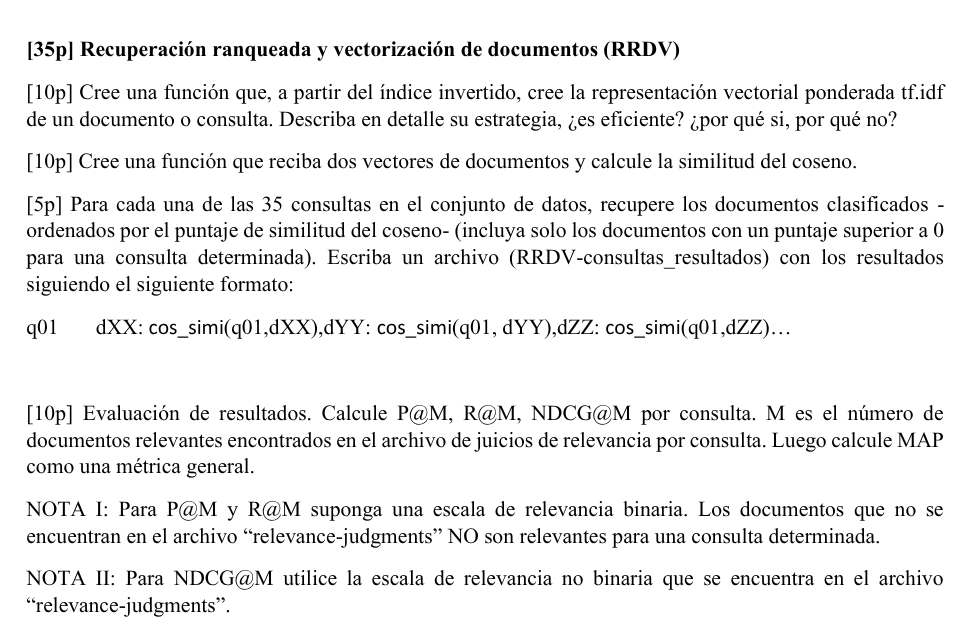

In [108]:
text_1 = get_content_and_title("wes2015.d001.naf")
tokens_1 = process_text_stop_words(text_1)

text_2 = get_content_and_title("wes2015.d002.naf")
tokens_2 = process_text_stop_words(text_2)



William Beaumont and the Human Digestion
 William Beaumont and the Human Digestion.

William Beaumont: Physiology of digestion Image Source.  On November 21, 1785, US-American surgeon William Beaumont was born. He became best known as Father of Gastric Physiology following his research on human digestion. William Beaumont was born in Lebanon, Connecticut and became a physician. He served as a surgeons mate in the Army during the War of 1812. He opened a private practice in Plattsburgh, New York, but rejoined the Army as a surgeon in 1819. Beaumont was stationed at Fort Mackinac on Mackinac Island in Michigan in the early 1820s when it existed to protect the interests of the American Fur Company. The fort became the refuge for a wounded 19-year-old French-Canadian fur trader named Alexis St. Martin when a shotgun went off by accident in the American Fur Company store at close range June 6th, 1822. St. Martins wound was quite serious because his stomach was perforated and several ribs we

In [109]:
for word in inverted_index.word_list:
    print(inverted_index.get(word))
    print(inverted_index.get(word)[1],len(inverted_index.get(word)[2]))

['william', 50, [[1, 6], [9, 1], [15, 6], [28, 5], [35, 2], [55, 4], [56, 5], [69, 6], [78, 4], [88, 3], [91, 1], [92, 1], [95, 1], [98, 2], [102, 5], [106, 1], [109, 1], [111, 1], [129, 1], [136, 8], [138, 3], [147, 1], [175, 1], [179, 2], [180, 1], [189, 2], [190, 1], [191, 1], [193, 1], [197, 1], [212, 1], [230, 1], [231, 1], [241, 2], [254, 1], [257, 1], [266, 2], [272, 1], [273, 8], [274, 1], [289, 1], [291, 1], [294, 1], [299, 1], [300, 1], [309, 1], [310, 5], [320, 6], [323, 1], [330, 7]]]
50 50
['beaumont', 1, [[1, 13]]]
1 1
['human', 59, [[1, 3], [2, 1], [7, 1], [12, 1], [32, 1], [36, 1], [46, 4], [50, 1], [51, 1], [53, 4], [54, 3], [55, 1], [62, 1], [84, 1], [86, 1], [91, 1], [102, 3], [113, 1], [118, 1], [120, 1], [131, 1], [146, 2], [161, 1], [173, 3], [174, 5], [190, 1], [191, 1], [192, 1], [194, 2], [197, 1], [198, 1], [204, 2], [206, 5], [210, 6], [213, 2], [215, 1], [219, 1], [222, 2], [232, 2], [241, 1], [249, 3], [251, 2], [261, 1], [263, 1], [266, 3], [276, 1], [279,

In [110]:
vector_tf_idf_1 = inverted_index.create_tf_idf(1)
vector_tf_idf_2 = inverted_index.create_tf_idf(2)
inverted_index.cosine_similarity(vector_tf_idf_1,vector_tf_idf_2)

0.013032793154465164

In [111]:
import os
import time

list_query_files = sorted(os.listdir("./data/queries-raw-texts/"))
output_path = "RRDV-consultas_resultado"

start_time = time.time()

#with open(output_path, "w", encoding="utf-8") as out:
for qid, document in enumerate(list_query_files, start=1):
    text = get_content(document)
    
    tokens = process_text_stop_words(text)
    print(text)
    print(tokens)
    vector_tf_idf = inverted_index.create_tf_idf(
        1, token_list=tokens, is_document=False
    )

    results = inverted_index.cosine_search(vector_tf_idf)


    results = [(doc, score) for doc, score in results if score > 0]
    results.sort(key=lambda x: x[1], reverse=True)


    docs_str = ",".join(
        f"d{int(doc):03d}:{score:.4f}" for doc, score in results
    )

    line = f"q{qid:02d} {docs_str}" if docs_str else f"q{qid:02d} "


end_time = time.time()
print(f"Listo: escrito '{output_path}' en {end_time - start_time:.3f}s")


Fabrication of music instruments
Fabrication of music instruments
['fabric', 'music', 'instrument']
famous German poetry
famous German poetry
['famous', 'german', 'poetri']
Romanticism
Romanticism
['romanticism']
University of Edinburgh research
University of Edinburgh research
['univers', 'edinburgh', 'research']
bridge construction
bridge construction
['bridg', 'construct']
Walk of Fame stars
Walk of Fame stars
['walk', 'fame', 'star']
Scientists who worked on the atomic bomb
Scientists who worked on the atomic bomb
['scientist', 'work', 'atom', 'bomb']
Invention of the Internet
Invention of the Internet
['invent', 'internet']
early telecommunication methods
early telecommunication methods
['earli', 'telecommun', 'method']
Who explored the South Pole
Who explored the South Pole
['explor', 'south', 'pole']
famous members of the Royal Navy
famous members of the Royal Navy
['famous', 'member', 'royal', 'navi']
Nobel Prize winning inventions
Nobel Prize winning inventions
['nobel', 'priz

In [112]:
consultas = {}

In [113]:
import re

q_to_docs = {}

with open("./data/relevance-judgments.tsv", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        qid, pairs = line.split(None, 1)  

        m = re.search(r"(\d+)", qid)
        if not m:
            continue
        qnum = int(m.group(1))
        docs = []
        for p in pairs.split(","):
            p = p.strip()
            if not p:
                continue
            doc_id = int(p.split(":", 1)[0].replace("d",""))
            docs.append(doc_id)

        q_to_docs[qnum] = docs
q_to_docs


{1: [186, 254, 16],
 2: [136, 139, 143, 283, 228, 164, 318, 291, 293, 147, 149],
 3: [152, 291, 283, 147, 318, 105],
 4: [275, 10, 286, 19, 49, 330, 270],
 6: [69, 233, 257, 297, 26, 329],
 7: [4, 77, 266, 179],
 8: [205, 5, 110, 108, 117, 81, 292, 251, 28, 271, 121, 180],
 9: [205, 199, 198, 223, 217, 177],
 10: [68, 100, 65, 76, 231, 199, 52, 215],
 12: [239, 277, 258, 250],
 13: [239, 277, 258, 49, 56],
 14: [2, 5, 142, 314, 280, 130, 41, 117, 81, 93, 91, 180],
 16: [229, 132],
 17: [280, 271, 121, 91],
 18: [207, 201, 192, 194, 222, 216, 210],
 19: [77, 179],
 22: [277, 11, 132, 258, 49, 250, 331],
 23: [205, 202, 276, 194, 216, 219, 215, 211],
 24: [98, 129, 196, 221, 60],
 25: [167, 166, 20, 23],
 26: [152],
 27: [103, 143, 107, 51, 17, 54, 293, 158],
 28: [136, 316, 94],
 29: [1, 37, 130, 314, 46, 133, 113, 294, 261, 93, 62, 120],
 32: [139, 67, 25, 31, 90],
 34: [248],
 36: [277, 167, 257, 20, 23, 321, 247, 265, 150, 328],
 37: [169, 256, 116],
 38: [235, 39, 229, 317, 15, 250,

In [114]:
query_results_matrix = []
relevant_counts = []

for qid, document in enumerate(list_query_files, start=1):
    text = get_content(document)
    tokens = process_text_stop_words(text)

    vector_tf_idf = inverted_index.create_tf_idf(
        1, token_list=tokens, is_document=False
    )

    results = inverted_index.cosine_search(vector_tf_idf)
    results = [doc for doc, score in results if score > 0]

    if qid in q_to_docs:  
        ground_truth = q_to_docs[qid]
        final_result = [1 if doc in ground_truth else 0 for doc in results]
        relevant_counts.append(len(ground_truth))
    else:
        final_result = [0 for doc in results]
        relevant_counts.append(0) 

    query_results_matrix.append(np.array(final_result))

map_score = mean_average_precision(query_results_matrix)
mar_score = mean_average_recall(query_results_matrix, relevant_counts)

print("MAP:", map_score)
print("MAR:", mar_score)

Fabrication of music instruments
famous German poetry
Romanticism
University of Edinburgh research
bridge construction
Walk of Fame stars
Scientists who worked on the atomic bomb
Invention of the Internet
early telecommunication methods
Who explored the South Pole
famous members of the Royal Navy
Nobel Prize winning inventions
South America
Edward Teller and Marie Curie
Computing Language for the programming of Artificial Intelligence
William Hearst movie
How did Captain James Cook become an explorer
How did Grace Hopper get famous
Computers in Astronomy
WWII aircraft
Literary critics on Thomas Moore
Nazis confiscate or destroy art and literature
Modern Age in English Literature
modern Physiology
Roman Empire
Scientists who have contributed to photosynthesis
Aviation pioneers' publications
Gutenberg Bible
Religious beliefs of scientists and explorers
Carl Friedrich Gauss influence on colleagues
Personalities from Hannover
Skinner's experiments with the operant conditioning chamber
Napo

## Gensim

In [115]:
import re

q_to_docs = {}

with open("./data/relevance-judgments.tsv", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        qid, pairs = line.split(None, 1)  

        m = re.search(r"(\d+)", qid)
        if not m:
            continue
        qnum = int(m.group(1))
        docs = []
        for p in pairs.split(","):
            p = p.strip()
            if not p:
                continue
            doc_id = int(p.split(":", 1)[0].replace("d",""))
            docs.append(doc_id)

        q_to_docs[qnum] = docs
q_to_docs


{1: [186, 254, 16],
 2: [136, 139, 143, 283, 228, 164, 318, 291, 293, 147, 149],
 3: [152, 291, 283, 147, 318, 105],
 4: [275, 10, 286, 19, 49, 330, 270],
 6: [69, 233, 257, 297, 26, 329],
 7: [4, 77, 266, 179],
 8: [205, 5, 110, 108, 117, 81, 292, 251, 28, 271, 121, 180],
 9: [205, 199, 198, 223, 217, 177],
 10: [68, 100, 65, 76, 231, 199, 52, 215],
 12: [239, 277, 258, 250],
 13: [239, 277, 258, 49, 56],
 14: [2, 5, 142, 314, 280, 130, 41, 117, 81, 93, 91, 180],
 16: [229, 132],
 17: [280, 271, 121, 91],
 18: [207, 201, 192, 194, 222, 216, 210],
 19: [77, 179],
 22: [277, 11, 132, 258, 49, 250, 331],
 23: [205, 202, 276, 194, 216, 219, 215, 211],
 24: [98, 129, 196, 221, 60],
 25: [167, 166, 20, 23],
 26: [152],
 27: [103, 143, 107, 51, 17, 54, 293, 158],
 28: [136, 316, 94],
 29: [1, 37, 130, 314, 46, 133, 113, 294, 261, 93, 62, 120],
 32: [139, 67, 25, 31, 90],
 34: [248],
 36: [277, 167, 257, 20, 23, 321, 247, 265, 150, 328],
 37: [169, 256, 116],
 38: [235, 39, 229, 317, 15, 250,

In [116]:
from gensim.corpora import Dictionary
from gensim import models,similarities
from gensim.utils import simple_preprocess

list_query_files = sorted(os.listdir("./data/queries-raw-texts/"))
def get_content_gensim(document, is_document=True):
    if is_document:
        tree = ET.parse(f"./data/docs-raw-texts/{document}")
        root = tree.getroot()
        file_desc = root.find(".//fileDesc")
        element_raw = root.find("raw")
        if file_desc is not None:
            title = file_desc.attrib.get("title")
        text = f"{title}\n {element_raw.text}"
        idx = int(document.split(".")[1].strip("d"))
    else:
        tree = ET.parse(f"./data/queries-raw-texts/{document}")
        root = tree.getroot()
        element_raw = root.find("raw").text
        text = element_raw
        idx = int(document.split(".")[1].strip("q"))
    return idx,text

lists_tokens_docs = []
docs_ids = []
for document in list_docs_files:
    idx, text = get_content_gensim(document)
    text = simple_preprocess(text, deacc=True, min_len=2, max_len=30)
    lists_tokens_docs.append(text)
    docs_ids.append(idx)

# Obtengo bow
dictionary = Dictionary(lists_tokens_docs)
bow_corpus = [dictionary.doc2bow(tokens) for tokens in lists_tokens_docs]
# Transformo en TF IDF 
tfidf = models.TfidfModel(bow_corpus, normalize=True)
tfidf_corpus = tfidf[bow_corpus]
# Indice basado en similitud coseno 
index = similarities.SparseMatrixSimilarity(tfidf_corpus, num_features=len(dictionary))
# Desarrollo de los resultados de las queries 

query_results_matrix = []
relevant_counts = []

salida = []

for document in list_query_files:
    idx, text = get_content_gensim(document, is_document=False)
    text = simple_preprocess(text, deacc=True, min_len=2, max_len=30)
    query_vector = tfidf[dictionary.doc2bow(text)]

    sims = index[query_vector] 

    pares = [(docs_ids[i], float(sims[i])) for i in range(len(docs_ids))]
    pares = [(d, s) for (d, s) in pares if s > 0.0]

    pares.sort(key=lambda x: x[1], reverse=True)

    if pares:
        linea = "q" + str(idx) + " " + ", ".join([f"{d}: {s:.6f}" for d, s in pares])
    else:
        linea = idx
    salida.append((idx, linea))

    if idx in q_to_docs:  
        ground_truth = q_to_docs[idx]
        final_result = [1 if doc[0] in ground_truth else 0 for doc in pares]

        final_result_ndcg = []
        relevant_counts.append(len(ground_truth))
    #else:
        #final_result = [0 for doc in pares]
        #relevant_counts.append(0) 
    query_results_matrix.append(np.array(final_result))
salida.sort(key=lambda t: t[0])

with open("GESIM-consultas_resultados", "w", encoding="utf-8") as f:
    for _, linea in salida:
        f.write(linea + "\n")

print("Archivo escrito: GESIM-consultas_resultados")

map_score = mean_average_precision(query_results_matrix)
mar_score = mean_average_recall(query_results_matrix, relevant_counts)
ndcg = ndcg_at_k
print("MAP:", map_score)  
print("MAR:", mar_score) 

Archivo escrito: GESIM-consultas_resultados
MAP: 0.6879069408798658
MAR: 0.6035492681921253
